In [19]:
from reservoirpy.datasets import lorenz, mackey_glass
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.nodes import Reservoir
# Load data
x = lorenz(10000)
offset = -np.min(x, axis=0)
offset[offset < 0] = 0
x += offset
x /= np.max(x)
timeseries = x[:, 0].reshape(-1, 1)
# timeseries = x.reshape((-1, 3))
print(timeseries.shape)
print(np.max(timeseries))
print(np.min(timeseries))



(10000, 1)
0.7246638513467922
0.0


### Classical, using reservoirpy

In [20]:

res = Reservoir(500, lr=0.5, sr=0.9)
states = res.run(timeseries)


In [21]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

WARMUP = 0.1

warmup = int(len(states) * WARMUP)
x = states[:-1]
target = timeseries[1:]

x = x[warmup:]
target = target[warmup:]

# train_x, test_x, train_y, test_y = train_test_split(x, target, test_size=0.33)
M = 3 * len(x) // 4
train_x = x[:M]
train_y = target[:M]

test_x = x[M:]
test_y = target[M:]
model = make_pipeline(StandardScaler(), Ridge(alpha=1e-7))
model.fit(train_x, train_y)
print(model.score(test_x, test_y))


0.9999996377424734


In [22]:
res = res.reset()
trainy_states = res.run(train_y)

from_state = trainy_states[-2]

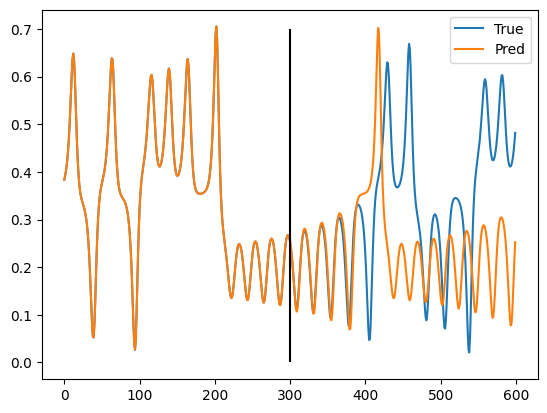

In [23]:
N = 300

pred = train_y.copy()

res = res.reset()
res.run(train_y[-1], from_state=from_state)

for _ in range(N):
    last = pred[-1]
    state = res.run(last)
    val = model.predict(state)
    pred = np.append(pred, val[0])


true = np.append(train_y, test_y[:len(pred) - len(train_y)])
plt.plot(true[-2*N:], label="True")
plt.plot(pred[-2*N:], label="Pred")
plt.vlines(N, ymin=0, ymax=0.7, colors="k")
plt.legend()
# plt.plot(x[:len(pred)][-2*N:])

### Quantum, using QReservoirpy

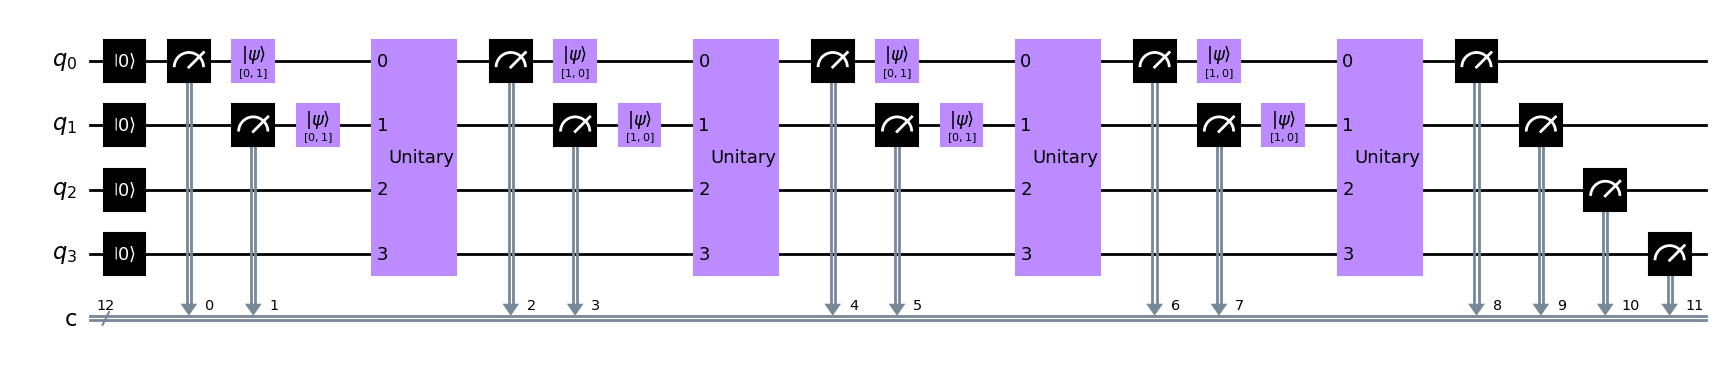

In [24]:
from qreservoirpy import QReservoir, Layers
from qiskit.quantum_info import random_unitary

def build_method(circ, timestep, operator):
    vec = np.array([np.sqrt(timestep),
        np.sqrt(1-timestep)], dtype=complex
    )
    for i in range(2):
        circ.measure(i)
        circ.initialize(vec, i)
    circ.unitary(operator, circ.qubits)
    return circ

n_qubits = 4
qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method),
    Layers.Measurement(range(n_qubits))
], operator=random_unitary(2**n_qubits), 
analyze_function=lambda res: res[-n_qubits - 2:], M=10)


qres.circuit.draw('mpl')




In [25]:
SHOTS = 1000
quantum_timeseries = timeseries.ravel()[:8000]
states = qres.run(quantum_timeseries, incrementally=True, shots=SHOTS)

Simulating: 100%|██████████| 8000/8000 [24:38<00:00,  5.41it/s]


In [26]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

WARMUP = 0.1

warmup = int(len(states) * WARMUP)
x = states[:-1]
target = quantum_timeseries[1:]

x = x[warmup:]
target = target[warmup:]

# train_x, test_x, train_y, test_y = train_test_split(x, target, test_size=0.33)
M = 3 * len(x) // 4
train_x = x[:M]
train_y = target[:M]

test_x = x[M:]
test_y = target[M:]
model = make_pipeline(StandardScaler(), Ridge(alpha=1e-7))
model.fit(train_x, train_y)
print(model.score(test_x, test_y))


0.9449887931742448


Subsys: 100%|██████████| 50/50 [08:00<00:00,  9.61s/it]


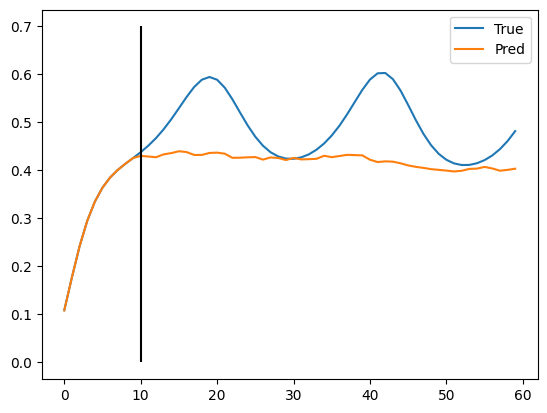

In [37]:
from tqdm import tqdm
num_prev = 10
pred_series = quantum_timeseries[-num_prev:]

num_pred = 50
num_subsys = 50
preds = np.zeros((num_subsys, num_pred + num_prev))
for i in tqdm(range(num_subsys), desc="Subsys", position=0):
    preds[i] = qres.predict(num_pred, model, pred_series, SHOTS, low=0, high=1)
pred_series = np.average(preds, axis=0)

true = np.append(quantum_timeseries[-num_prev:], timeseries[len(quantum_timeseries):len(quantum_timeseries) + num_pred])
plt.plot(true[:num_pred + num_prev], label="True")
plt.plot(pred_series[:num_prev + num_pred], label="Pred")
plt.vlines(num_prev, ymin=0, ymax=0.7, colors="k")
plt.legend()